# Recommendation system
### Using Doc2Vec to build a poetry recommender
- The first step is to import necessary libraries.

In [317]:
# custom functions for this project
from functions import *
from functions_rec_tests import *

# dataframe libraries
import pandas as pd
import numpy as np

# graphing libraries
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style('ticks')

# rec system libraries
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim import matutils, models
from gensim.utils import simple_preprocess
from sklearn.manifold import TSNE

# miscellany
import re
from collections import Counter
import time
import gzip
import pickle

# reload functions/libraries when edited
%load_ext autoreload
%autoreload 2

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# increase column width of dataframe
pd.set_option('max_colwidth', 150)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Import necessary dataframe
- I'll be importing a dataframe containing all the original genres, since those will be more useful in a recommendation system.
- Then I'll re-create the umbrella genres in case I want those in the future.

In [223]:
# import necessary dataframe
with gzip.open('data/poetry_all_genres_df_edit.pkl', 'rb') as hello:
    df = pickle.load(hello)

In [224]:
# sort genres into umbrella genres
conditions = [
    df.genre == 'victorian', df.genre == 'romantic',
    df.genre == 'new_york_school', df.genre == 'new_york_school_2nd_generation', df.genre == 'confessional',
        df.genre == 'beat', df.genre == 'harlem_renaissance', df.genre == 'black_arts_movement',
    df.genre == 'imagist', df.genre == 'black_mountain', df.genre == 'language_poetry', df.genre == 'objectivist',
    df.genre == 'georgian', df.genre == 'fugitive'
]

# name umbrella genres, prepare 'other' to be dropped
choices = [
    'pre_1900', 'pre_1900',
    'metropolitan', 'metropolitan', 'metropolitan', 'metropolitan', 'metropolitan', 'metropolitan',
    'avant_garde', 'avant_garde', 'avant_garde', 'avant_garde',
    'other', 'other'
]

# convert data, leaving 'modern' untouched
df['umbrella_genre'] = np.select(conditions, choices, df.genre)

In [225]:
# take a look at columns
df.columns

Index(['poet_url', 'genre', 'poem_url', 'poet', 'title', 'poem_lines',
       'poem_string', 'clean_lines', 'num_lines', 'num_words', 'avg_len_line',
       'sentiment_polarity_score', 'sentiment_polarity',
       'sentiment_subjectivity_score', 'num_end_rhymes', 'end_rhyme_ratio',
       'end_rhyme', 'num_syllables', 'avg_syllables_word', 'lines_titled',
       'string_titled', 'string_cleaned', 'umbrella_genre'],
      dtype='object')

In [226]:
# drop poems in 'other' umbrella genre
df = df[df.umbrella_genre != 'other']

# take necessary columns
df = df[['title', 'poet', 'genre', 'umbrella_genre', 'num_lines', 'avg_len_line', 'sentiment_polarity',
         'end_rhyme', 'poem_url', 'string_titled']]

# reset the index
df.reset_index(drop=True, inplace=True)

### Save/Load dataframe specifically for the recommendation system

In [227]:
# uncomment to save
with gzip.open('data/poetry_rec_system.pkl', 'wb') as goodbye:
    pickle.dump(df, goodbye, protocol=pickle.HIGHEST_PROTOCOL)
    
# uncomment to load
with gzip.open('data/poetry_rec_system.pkl', 'rb') as hello:
    df = pickle.load(hello)

### Build the corpus

In [228]:
# create corpus with the string of every poem (including title)
corpus = df.string_titled

In [229]:
# instantiate an empty list
model_corpus = []
# loop over corpus and create tags in the process
for i, line in enumerate(corpus):
    # use Gensim's built-in preprocessing to tokenize strings
    tokens = simple_preprocess(line)
    # convert poems to necessary TaggedDocument format
    model_corpus.append(TaggedDocument(tokens, [i]))

## Build the model
- There is some debate over whether or not to train models with epochs from the getgo, or to train each epoch as part of a loop.
    - Based on several run-throughs, the loop yielded best results.
- The following parameters and loop borrow heavily from William Morgan's work: https://medium.com/@morga046/multi-class-text-classification-with-doc2vec-and-t-sne-a-full-tutorial-55eb24fc40d3

In [264]:
# instantiate the model, setting size of our vectors to 100, only including words that appear at least twice,
# looking at words in the range of five before and five after the current word, setting the learning rate
# and stopping point, and using all cores
model = Doc2Vec(vector_size=100, min_count=2, window=5, alpha=.025, min_alpha=0.00025, workers=8)

# build the vocabulary for the model based on the above settings
model.build_vocab(model_corpus)

collecting all words and their counts
PROGRESS: at example #0, processed 0 words (0/s), 0 word types, 0 tags
collected 43882 word types and 4376 unique tags from a corpus of 4376 examples and 1000709 words
Loading a fresh vocabulary
effective_min_count=2 retains 25044 unique words (57% of original 43882, drops 18838)
effective_min_count=2 leaves 981871 word corpus (98% of original 1000709, drops 18838)
deleting the raw counts dictionary of 43882 items
sample=0.001 downsamples 45 most-common words
downsampling leaves estimated 770218 word corpus (78.4% of prior 981871)
estimated required memory for 25044 words and 100 dimensions: 34307600 bytes
resetting layer weights


In [265]:
# here is where we'll set the number of epochs
epochs = range(50)

# loop over one at a time
for epoch in epochs:
    # keep track of progress
    print(f'Epoch {epoch+1}')
    
    # train the model
    model.train(model_corpus, total_examples=model.corpus_count, epochs=model.epochs)
    
    # manually decrease the learning rate
    model.alpha -= 0.00025
    
    # fix the learning rate, no decay
    model.min_alpha = model.alpha

training model with 8 workers on 25044 vocabulary and 100 features, using sg=0 hs=0 sample=0.001 negative=5 window=5


Epoch 1


worker thread finished; awaiting finish of 7 more threads
worker thread finished; awaiting finish of 6 more threads
worker thread finished; awaiting finish of 5 more threads
worker thread finished; awaiting finish of 4 more threads
worker thread finished; awaiting finish of 3 more threads
worker thread finished; awaiting finish of 2 more threads
worker thread finished; awaiting finish of 1 more threads
worker thread finished; awaiting finish of 0 more threads
EPOCH - 1 : training on 1000709 raw words (774263 effective words) took 0.8s, 994716 effective words/s
worker thread finished; awaiting finish of 7 more threads
worker thread finished; awaiting finish of 6 more threads
worker thread finished; awaiting finish of 5 more threads
worker thread finished; awaiting finish of 4 more threads
worker thread finished; awaiting finish of 3 more threads
worker thread finished; awaiting finish of 2 more threads
worker thread finished; awaiting finish of 1 more threads
worker thread finished; awa

Epoch 2


worker thread finished; awaiting finish of 7 more threads
worker thread finished; awaiting finish of 6 more threads
worker thread finished; awaiting finish of 5 more threads
worker thread finished; awaiting finish of 4 more threads
worker thread finished; awaiting finish of 3 more threads
worker thread finished; awaiting finish of 2 more threads
worker thread finished; awaiting finish of 1 more threads
worker thread finished; awaiting finish of 0 more threads
EPOCH - 1 : training on 1000709 raw words (774396 effective words) took 0.7s, 1080551 effective words/s
worker thread finished; awaiting finish of 7 more threads
worker thread finished; awaiting finish of 6 more threads
worker thread finished; awaiting finish of 5 more threads
worker thread finished; awaiting finish of 4 more threads
worker thread finished; awaiting finish of 3 more threads
worker thread finished; awaiting finish of 2 more threads
worker thread finished; awaiting finish of 1 more threads
worker thread finished; aw

Epoch 3


worker thread finished; awaiting finish of 7 more threads
worker thread finished; awaiting finish of 6 more threads
worker thread finished; awaiting finish of 5 more threads
worker thread finished; awaiting finish of 4 more threads
worker thread finished; awaiting finish of 3 more threads
worker thread finished; awaiting finish of 2 more threads
worker thread finished; awaiting finish of 1 more threads
worker thread finished; awaiting finish of 0 more threads
EPOCH - 1 : training on 1000709 raw words (774525 effective words) took 0.8s, 1031359 effective words/s
worker thread finished; awaiting finish of 7 more threads
worker thread finished; awaiting finish of 6 more threads
worker thread finished; awaiting finish of 5 more threads
worker thread finished; awaiting finish of 4 more threads
worker thread finished; awaiting finish of 3 more threads
worker thread finished; awaiting finish of 2 more threads
worker thread finished; awaiting finish of 1 more threads
worker thread finished; aw

Epoch 4


worker thread finished; awaiting finish of 7 more threads
worker thread finished; awaiting finish of 6 more threads
worker thread finished; awaiting finish of 5 more threads
worker thread finished; awaiting finish of 4 more threads
worker thread finished; awaiting finish of 3 more threads
worker thread finished; awaiting finish of 2 more threads
worker thread finished; awaiting finish of 1 more threads
worker thread finished; awaiting finish of 0 more threads
EPOCH - 1 : training on 1000709 raw words (774768 effective words) took 0.7s, 1061488 effective words/s
worker thread finished; awaiting finish of 7 more threads
worker thread finished; awaiting finish of 6 more threads
worker thread finished; awaiting finish of 5 more threads
worker thread finished; awaiting finish of 4 more threads
worker thread finished; awaiting finish of 3 more threads
worker thread finished; awaiting finish of 2 more threads
worker thread finished; awaiting finish of 1 more threads
worker thread finished; aw

Epoch 5


worker thread finished; awaiting finish of 7 more threads
worker thread finished; awaiting finish of 6 more threads
worker thread finished; awaiting finish of 5 more threads
worker thread finished; awaiting finish of 4 more threads
worker thread finished; awaiting finish of 3 more threads
worker thread finished; awaiting finish of 2 more threads
worker thread finished; awaiting finish of 1 more threads
worker thread finished; awaiting finish of 0 more threads
EPOCH - 1 : training on 1000709 raw words (774424 effective words) took 0.7s, 1052789 effective words/s
worker thread finished; awaiting finish of 7 more threads
worker thread finished; awaiting finish of 6 more threads
worker thread finished; awaiting finish of 5 more threads
worker thread finished; awaiting finish of 4 more threads
worker thread finished; awaiting finish of 3 more threads
worker thread finished; awaiting finish of 2 more threads
worker thread finished; awaiting finish of 1 more threads
worker thread finished; aw

Epoch 6


worker thread finished; awaiting finish of 7 more threads
worker thread finished; awaiting finish of 6 more threads
worker thread finished; awaiting finish of 5 more threads
worker thread finished; awaiting finish of 4 more threads
worker thread finished; awaiting finish of 3 more threads
worker thread finished; awaiting finish of 2 more threads
worker thread finished; awaiting finish of 1 more threads
worker thread finished; awaiting finish of 0 more threads
EPOCH - 1 : training on 1000709 raw words (774953 effective words) took 0.8s, 923428 effective words/s
worker thread finished; awaiting finish of 7 more threads
worker thread finished; awaiting finish of 6 more threads
worker thread finished; awaiting finish of 5 more threads
worker thread finished; awaiting finish of 4 more threads
worker thread finished; awaiting finish of 3 more threads
worker thread finished; awaiting finish of 2 more threads
worker thread finished; awaiting finish of 1 more threads
worker thread finished; awa

Epoch 7


worker thread finished; awaiting finish of 7 more threads
worker thread finished; awaiting finish of 6 more threads
worker thread finished; awaiting finish of 5 more threads
worker thread finished; awaiting finish of 4 more threads
worker thread finished; awaiting finish of 3 more threads
worker thread finished; awaiting finish of 2 more threads
worker thread finished; awaiting finish of 1 more threads
worker thread finished; awaiting finish of 0 more threads
EPOCH - 1 : training on 1000709 raw words (774454 effective words) took 0.8s, 985758 effective words/s
worker thread finished; awaiting finish of 7 more threads
worker thread finished; awaiting finish of 6 more threads
worker thread finished; awaiting finish of 5 more threads
worker thread finished; awaiting finish of 4 more threads
worker thread finished; awaiting finish of 3 more threads
worker thread finished; awaiting finish of 2 more threads
worker thread finished; awaiting finish of 1 more threads
worker thread finished; awa

Epoch 8


worker thread finished; awaiting finish of 7 more threads
worker thread finished; awaiting finish of 6 more threads
worker thread finished; awaiting finish of 5 more threads
worker thread finished; awaiting finish of 4 more threads
worker thread finished; awaiting finish of 3 more threads
worker thread finished; awaiting finish of 2 more threads
worker thread finished; awaiting finish of 1 more threads
worker thread finished; awaiting finish of 0 more threads
EPOCH - 1 : training on 1000709 raw words (774602 effective words) took 0.8s, 923865 effective words/s
worker thread finished; awaiting finish of 7 more threads
worker thread finished; awaiting finish of 6 more threads
worker thread finished; awaiting finish of 5 more threads
worker thread finished; awaiting finish of 4 more threads
worker thread finished; awaiting finish of 3 more threads
worker thread finished; awaiting finish of 2 more threads
worker thread finished; awaiting finish of 1 more threads
worker thread finished; awa

Epoch 9


worker thread finished; awaiting finish of 7 more threads
worker thread finished; awaiting finish of 6 more threads
worker thread finished; awaiting finish of 5 more threads
worker thread finished; awaiting finish of 4 more threads
worker thread finished; awaiting finish of 3 more threads
worker thread finished; awaiting finish of 2 more threads
worker thread finished; awaiting finish of 1 more threads
worker thread finished; awaiting finish of 0 more threads
EPOCH - 1 : training on 1000709 raw words (774447 effective words) took 1.0s, 809201 effective words/s
worker thread finished; awaiting finish of 7 more threads
worker thread finished; awaiting finish of 6 more threads
worker thread finished; awaiting finish of 5 more threads
worker thread finished; awaiting finish of 4 more threads
worker thread finished; awaiting finish of 3 more threads
worker thread finished; awaiting finish of 2 more threads
worker thread finished; awaiting finish of 1 more threads
worker thread finished; awa

Epoch 10


worker thread finished; awaiting finish of 7 more threads
worker thread finished; awaiting finish of 6 more threads
worker thread finished; awaiting finish of 5 more threads
worker thread finished; awaiting finish of 4 more threads
worker thread finished; awaiting finish of 3 more threads
worker thread finished; awaiting finish of 2 more threads
worker thread finished; awaiting finish of 1 more threads
worker thread finished; awaiting finish of 0 more threads
EPOCH - 1 : training on 1000709 raw words (774612 effective words) took 0.9s, 885292 effective words/s
worker thread finished; awaiting finish of 7 more threads
worker thread finished; awaiting finish of 6 more threads
worker thread finished; awaiting finish of 5 more threads
worker thread finished; awaiting finish of 4 more threads
worker thread finished; awaiting finish of 3 more threads
worker thread finished; awaiting finish of 2 more threads
worker thread finished; awaiting finish of 1 more threads
worker thread finished; awa

Epoch 11


worker thread finished; awaiting finish of 7 more threads
worker thread finished; awaiting finish of 6 more threads
worker thread finished; awaiting finish of 5 more threads
worker thread finished; awaiting finish of 4 more threads
worker thread finished; awaiting finish of 3 more threads
worker thread finished; awaiting finish of 2 more threads
worker thread finished; awaiting finish of 1 more threads
worker thread finished; awaiting finish of 0 more threads
EPOCH - 1 : training on 1000709 raw words (774842 effective words) took 0.7s, 1093660 effective words/s
worker thread finished; awaiting finish of 7 more threads
worker thread finished; awaiting finish of 6 more threads
worker thread finished; awaiting finish of 5 more threads
worker thread finished; awaiting finish of 4 more threads
worker thread finished; awaiting finish of 3 more threads
worker thread finished; awaiting finish of 2 more threads
worker thread finished; awaiting finish of 1 more threads
worker thread finished; aw

Epoch 12


worker thread finished; awaiting finish of 7 more threads
worker thread finished; awaiting finish of 6 more threads
worker thread finished; awaiting finish of 5 more threads
worker thread finished; awaiting finish of 4 more threads
worker thread finished; awaiting finish of 3 more threads
worker thread finished; awaiting finish of 2 more threads
worker thread finished; awaiting finish of 1 more threads
worker thread finished; awaiting finish of 0 more threads
EPOCH - 1 : training on 1000709 raw words (774620 effective words) took 0.7s, 1098848 effective words/s
worker thread finished; awaiting finish of 7 more threads
worker thread finished; awaiting finish of 6 more threads
worker thread finished; awaiting finish of 5 more threads
worker thread finished; awaiting finish of 4 more threads
worker thread finished; awaiting finish of 3 more threads
worker thread finished; awaiting finish of 2 more threads
worker thread finished; awaiting finish of 1 more threads
worker thread finished; aw

Epoch 13


worker thread finished; awaiting finish of 7 more threads
worker thread finished; awaiting finish of 6 more threads
worker thread finished; awaiting finish of 5 more threads
worker thread finished; awaiting finish of 4 more threads
worker thread finished; awaiting finish of 3 more threads
worker thread finished; awaiting finish of 2 more threads
worker thread finished; awaiting finish of 1 more threads
worker thread finished; awaiting finish of 0 more threads
EPOCH - 1 : training on 1000709 raw words (774568 effective words) took 0.8s, 946880 effective words/s
worker thread finished; awaiting finish of 7 more threads
worker thread finished; awaiting finish of 6 more threads
worker thread finished; awaiting finish of 5 more threads
worker thread finished; awaiting finish of 4 more threads
worker thread finished; awaiting finish of 3 more threads
worker thread finished; awaiting finish of 2 more threads
worker thread finished; awaiting finish of 1 more threads
worker thread finished; awa

Epoch 14


worker thread finished; awaiting finish of 7 more threads
worker thread finished; awaiting finish of 6 more threads
worker thread finished; awaiting finish of 5 more threads
worker thread finished; awaiting finish of 4 more threads
worker thread finished; awaiting finish of 3 more threads
worker thread finished; awaiting finish of 2 more threads
worker thread finished; awaiting finish of 1 more threads
worker thread finished; awaiting finish of 0 more threads
EPOCH - 1 : training on 1000709 raw words (775055 effective words) took 0.8s, 917921 effective words/s
worker thread finished; awaiting finish of 7 more threads
worker thread finished; awaiting finish of 6 more threads
worker thread finished; awaiting finish of 5 more threads
worker thread finished; awaiting finish of 4 more threads
worker thread finished; awaiting finish of 3 more threads
worker thread finished; awaiting finish of 2 more threads
worker thread finished; awaiting finish of 1 more threads
worker thread finished; awa

Epoch 15


worker thread finished; awaiting finish of 7 more threads
worker thread finished; awaiting finish of 6 more threads
worker thread finished; awaiting finish of 5 more threads
worker thread finished; awaiting finish of 4 more threads
worker thread finished; awaiting finish of 3 more threads
worker thread finished; awaiting finish of 2 more threads
worker thread finished; awaiting finish of 1 more threads
worker thread finished; awaiting finish of 0 more threads
EPOCH - 1 : training on 1000709 raw words (774415 effective words) took 0.8s, 986392 effective words/s
worker thread finished; awaiting finish of 7 more threads
worker thread finished; awaiting finish of 6 more threads
worker thread finished; awaiting finish of 5 more threads
worker thread finished; awaiting finish of 4 more threads
worker thread finished; awaiting finish of 3 more threads
worker thread finished; awaiting finish of 2 more threads
worker thread finished; awaiting finish of 1 more threads
worker thread finished; awa

Epoch 16


worker thread finished; awaiting finish of 7 more threads
worker thread finished; awaiting finish of 6 more threads
worker thread finished; awaiting finish of 5 more threads
worker thread finished; awaiting finish of 4 more threads
worker thread finished; awaiting finish of 3 more threads
worker thread finished; awaiting finish of 2 more threads
worker thread finished; awaiting finish of 1 more threads
worker thread finished; awaiting finish of 0 more threads
EPOCH - 1 : training on 1000709 raw words (774597 effective words) took 0.7s, 1060934 effective words/s
worker thread finished; awaiting finish of 7 more threads
worker thread finished; awaiting finish of 6 more threads
worker thread finished; awaiting finish of 5 more threads
worker thread finished; awaiting finish of 4 more threads
worker thread finished; awaiting finish of 3 more threads
worker thread finished; awaiting finish of 2 more threads
worker thread finished; awaiting finish of 1 more threads
worker thread finished; aw

Epoch 17


worker thread finished; awaiting finish of 7 more threads
worker thread finished; awaiting finish of 6 more threads
worker thread finished; awaiting finish of 5 more threads
worker thread finished; awaiting finish of 4 more threads
worker thread finished; awaiting finish of 3 more threads
worker thread finished; awaiting finish of 2 more threads
worker thread finished; awaiting finish of 1 more threads
worker thread finished; awaiting finish of 0 more threads
EPOCH - 1 : training on 1000709 raw words (774681 effective words) took 0.8s, 960556 effective words/s
worker thread finished; awaiting finish of 7 more threads
worker thread finished; awaiting finish of 6 more threads
worker thread finished; awaiting finish of 5 more threads
worker thread finished; awaiting finish of 4 more threads
worker thread finished; awaiting finish of 3 more threads
worker thread finished; awaiting finish of 2 more threads
worker thread finished; awaiting finish of 1 more threads
worker thread finished; awa

Epoch 18


worker thread finished; awaiting finish of 7 more threads
worker thread finished; awaiting finish of 6 more threads
worker thread finished; awaiting finish of 5 more threads
worker thread finished; awaiting finish of 4 more threads
worker thread finished; awaiting finish of 3 more threads
worker thread finished; awaiting finish of 2 more threads
worker thread finished; awaiting finish of 1 more threads
worker thread finished; awaiting finish of 0 more threads
EPOCH - 1 : training on 1000709 raw words (774527 effective words) took 0.8s, 1013150 effective words/s
worker thread finished; awaiting finish of 7 more threads
worker thread finished; awaiting finish of 6 more threads
worker thread finished; awaiting finish of 5 more threads
worker thread finished; awaiting finish of 4 more threads
worker thread finished; awaiting finish of 3 more threads
worker thread finished; awaiting finish of 2 more threads
worker thread finished; awaiting finish of 1 more threads
worker thread finished; aw

Epoch 19


worker thread finished; awaiting finish of 7 more threads
worker thread finished; awaiting finish of 6 more threads
worker thread finished; awaiting finish of 5 more threads
worker thread finished; awaiting finish of 4 more threads
worker thread finished; awaiting finish of 3 more threads
worker thread finished; awaiting finish of 2 more threads
worker thread finished; awaiting finish of 1 more threads
worker thread finished; awaiting finish of 0 more threads
EPOCH - 1 : training on 1000709 raw words (774015 effective words) took 0.7s, 1049737 effective words/s
worker thread finished; awaiting finish of 7 more threads
worker thread finished; awaiting finish of 6 more threads
worker thread finished; awaiting finish of 5 more threads
worker thread finished; awaiting finish of 4 more threads
worker thread finished; awaiting finish of 3 more threads
worker thread finished; awaiting finish of 2 more threads
worker thread finished; awaiting finish of 1 more threads
worker thread finished; aw

Epoch 20


worker thread finished; awaiting finish of 7 more threads
worker thread finished; awaiting finish of 6 more threads
worker thread finished; awaiting finish of 5 more threads
worker thread finished; awaiting finish of 4 more threads
worker thread finished; awaiting finish of 3 more threads
worker thread finished; awaiting finish of 2 more threads
worker thread finished; awaiting finish of 1 more threads
worker thread finished; awaiting finish of 0 more threads
EPOCH - 1 : training on 1000709 raw words (775072 effective words) took 0.8s, 994115 effective words/s
worker thread finished; awaiting finish of 7 more threads
worker thread finished; awaiting finish of 6 more threads
worker thread finished; awaiting finish of 5 more threads
worker thread finished; awaiting finish of 4 more threads
worker thread finished; awaiting finish of 3 more threads
worker thread finished; awaiting finish of 2 more threads
worker thread finished; awaiting finish of 1 more threads
worker thread finished; awa

Epoch 21


worker thread finished; awaiting finish of 7 more threads
worker thread finished; awaiting finish of 6 more threads
worker thread finished; awaiting finish of 5 more threads
worker thread finished; awaiting finish of 4 more threads
worker thread finished; awaiting finish of 3 more threads
worker thread finished; awaiting finish of 2 more threads
worker thread finished; awaiting finish of 1 more threads
worker thread finished; awaiting finish of 0 more threads
EPOCH - 1 : training on 1000709 raw words (774385 effective words) took 0.7s, 1061252 effective words/s
worker thread finished; awaiting finish of 7 more threads
worker thread finished; awaiting finish of 6 more threads
worker thread finished; awaiting finish of 5 more threads
worker thread finished; awaiting finish of 4 more threads
worker thread finished; awaiting finish of 3 more threads
worker thread finished; awaiting finish of 2 more threads
worker thread finished; awaiting finish of 1 more threads
worker thread finished; aw

Epoch 22


worker thread finished; awaiting finish of 7 more threads
worker thread finished; awaiting finish of 6 more threads
worker thread finished; awaiting finish of 5 more threads
worker thread finished; awaiting finish of 4 more threads
worker thread finished; awaiting finish of 3 more threads
worker thread finished; awaiting finish of 2 more threads
worker thread finished; awaiting finish of 1 more threads
worker thread finished; awaiting finish of 0 more threads
EPOCH - 1 : training on 1000709 raw words (774476 effective words) took 0.8s, 1006200 effective words/s
worker thread finished; awaiting finish of 7 more threads
worker thread finished; awaiting finish of 6 more threads
worker thread finished; awaiting finish of 5 more threads
worker thread finished; awaiting finish of 4 more threads
worker thread finished; awaiting finish of 3 more threads
worker thread finished; awaiting finish of 2 more threads
worker thread finished; awaiting finish of 1 more threads
worker thread finished; aw

Epoch 23


worker thread finished; awaiting finish of 7 more threads
worker thread finished; awaiting finish of 6 more threads
worker thread finished; awaiting finish of 5 more threads
worker thread finished; awaiting finish of 4 more threads
worker thread finished; awaiting finish of 3 more threads
worker thread finished; awaiting finish of 2 more threads
worker thread finished; awaiting finish of 1 more threads
worker thread finished; awaiting finish of 0 more threads
EPOCH - 1 : training on 1000709 raw words (774202 effective words) took 0.8s, 980222 effective words/s
worker thread finished; awaiting finish of 7 more threads
worker thread finished; awaiting finish of 6 more threads
worker thread finished; awaiting finish of 5 more threads
worker thread finished; awaiting finish of 4 more threads
worker thread finished; awaiting finish of 3 more threads
worker thread finished; awaiting finish of 2 more threads
worker thread finished; awaiting finish of 1 more threads
worker thread finished; awa

Epoch 24


worker thread finished; awaiting finish of 7 more threads
worker thread finished; awaiting finish of 6 more threads
worker thread finished; awaiting finish of 5 more threads
worker thread finished; awaiting finish of 4 more threads
worker thread finished; awaiting finish of 3 more threads
worker thread finished; awaiting finish of 2 more threads
worker thread finished; awaiting finish of 1 more threads
worker thread finished; awaiting finish of 0 more threads
EPOCH - 1 : training on 1000709 raw words (774404 effective words) took 0.8s, 986939 effective words/s
worker thread finished; awaiting finish of 7 more threads
worker thread finished; awaiting finish of 6 more threads
worker thread finished; awaiting finish of 5 more threads
worker thread finished; awaiting finish of 4 more threads
worker thread finished; awaiting finish of 3 more threads
worker thread finished; awaiting finish of 2 more threads
worker thread finished; awaiting finish of 1 more threads
worker thread finished; awa

Epoch 25


worker thread finished; awaiting finish of 7 more threads
worker thread finished; awaiting finish of 6 more threads
worker thread finished; awaiting finish of 5 more threads
worker thread finished; awaiting finish of 4 more threads
worker thread finished; awaiting finish of 3 more threads
worker thread finished; awaiting finish of 2 more threads
worker thread finished; awaiting finish of 1 more threads
worker thread finished; awaiting finish of 0 more threads
EPOCH - 1 : training on 1000709 raw words (774503 effective words) took 0.7s, 1065956 effective words/s
worker thread finished; awaiting finish of 7 more threads
worker thread finished; awaiting finish of 6 more threads
worker thread finished; awaiting finish of 5 more threads
worker thread finished; awaiting finish of 4 more threads
worker thread finished; awaiting finish of 3 more threads
worker thread finished; awaiting finish of 2 more threads
worker thread finished; awaiting finish of 1 more threads
worker thread finished; aw

Epoch 26


worker thread finished; awaiting finish of 7 more threads
worker thread finished; awaiting finish of 6 more threads
worker thread finished; awaiting finish of 5 more threads
worker thread finished; awaiting finish of 4 more threads
worker thread finished; awaiting finish of 3 more threads
worker thread finished; awaiting finish of 2 more threads
worker thread finished; awaiting finish of 1 more threads
worker thread finished; awaiting finish of 0 more threads
EPOCH - 1 : training on 1000709 raw words (774604 effective words) took 0.9s, 881293 effective words/s
worker thread finished; awaiting finish of 7 more threads
worker thread finished; awaiting finish of 6 more threads
worker thread finished; awaiting finish of 5 more threads
worker thread finished; awaiting finish of 4 more threads
worker thread finished; awaiting finish of 3 more threads
worker thread finished; awaiting finish of 2 more threads
worker thread finished; awaiting finish of 1 more threads
worker thread finished; awa

Epoch 27


worker thread finished; awaiting finish of 7 more threads
worker thread finished; awaiting finish of 6 more threads
worker thread finished; awaiting finish of 5 more threads
worker thread finished; awaiting finish of 4 more threads
worker thread finished; awaiting finish of 3 more threads
worker thread finished; awaiting finish of 2 more threads
worker thread finished; awaiting finish of 1 more threads
worker thread finished; awaiting finish of 0 more threads
EPOCH - 1 : training on 1000709 raw words (774876 effective words) took 0.8s, 1032937 effective words/s
worker thread finished; awaiting finish of 7 more threads
worker thread finished; awaiting finish of 6 more threads
worker thread finished; awaiting finish of 5 more threads
worker thread finished; awaiting finish of 4 more threads
worker thread finished; awaiting finish of 3 more threads
worker thread finished; awaiting finish of 2 more threads
worker thread finished; awaiting finish of 1 more threads
worker thread finished; aw

Epoch 28


worker thread finished; awaiting finish of 7 more threads
worker thread finished; awaiting finish of 6 more threads
worker thread finished; awaiting finish of 5 more threads
worker thread finished; awaiting finish of 4 more threads
worker thread finished; awaiting finish of 3 more threads
worker thread finished; awaiting finish of 2 more threads
worker thread finished; awaiting finish of 1 more threads
worker thread finished; awaiting finish of 0 more threads
EPOCH - 1 : training on 1000709 raw words (774598 effective words) took 0.8s, 991291 effective words/s
EPOCH 2 - PROGRESS: at 94.88% examples, 692239 words/s, in_qsize 11, out_qsize 0
worker thread finished; awaiting finish of 7 more threads
worker thread finished; awaiting finish of 6 more threads
worker thread finished; awaiting finish of 5 more threads
worker thread finished; awaiting finish of 4 more threads
worker thread finished; awaiting finish of 3 more threads
worker thread finished; awaiting finish of 2 more threads
work

Epoch 29


worker thread finished; awaiting finish of 7 more threads
worker thread finished; awaiting finish of 6 more threads
worker thread finished; awaiting finish of 5 more threads
worker thread finished; awaiting finish of 4 more threads
worker thread finished; awaiting finish of 3 more threads
worker thread finished; awaiting finish of 2 more threads
worker thread finished; awaiting finish of 1 more threads
worker thread finished; awaiting finish of 0 more threads
EPOCH - 1 : training on 1000709 raw words (774375 effective words) took 1.0s, 812355 effective words/s
worker thread finished; awaiting finish of 7 more threads
worker thread finished; awaiting finish of 6 more threads
worker thread finished; awaiting finish of 5 more threads
worker thread finished; awaiting finish of 4 more threads
worker thread finished; awaiting finish of 3 more threads
worker thread finished; awaiting finish of 2 more threads
worker thread finished; awaiting finish of 1 more threads
worker thread finished; awa

Epoch 30


worker thread finished; awaiting finish of 7 more threads
worker thread finished; awaiting finish of 6 more threads
worker thread finished; awaiting finish of 5 more threads
worker thread finished; awaiting finish of 4 more threads
worker thread finished; awaiting finish of 3 more threads
worker thread finished; awaiting finish of 2 more threads
worker thread finished; awaiting finish of 1 more threads
worker thread finished; awaiting finish of 0 more threads
EPOCH - 1 : training on 1000709 raw words (774438 effective words) took 0.9s, 879321 effective words/s
EPOCH 2 - PROGRESS: at 89.33% examples, 649327 words/s, in_qsize 15, out_qsize 0
worker thread finished; awaiting finish of 7 more threads
worker thread finished; awaiting finish of 6 more threads
worker thread finished; awaiting finish of 5 more threads
worker thread finished; awaiting finish of 4 more threads
worker thread finished; awaiting finish of 3 more threads
worker thread finished; awaiting finish of 2 more threads
work

Epoch 31


worker thread finished; awaiting finish of 7 more threads
worker thread finished; awaiting finish of 6 more threads
worker thread finished; awaiting finish of 5 more threads
worker thread finished; awaiting finish of 4 more threads
worker thread finished; awaiting finish of 3 more threads
worker thread finished; awaiting finish of 2 more threads
worker thread finished; awaiting finish of 1 more threads
worker thread finished; awaiting finish of 0 more threads
EPOCH - 1 : training on 1000709 raw words (774876 effective words) took 1.0s, 800121 effective words/s
worker thread finished; awaiting finish of 7 more threads
worker thread finished; awaiting finish of 6 more threads
worker thread finished; awaiting finish of 5 more threads
worker thread finished; awaiting finish of 4 more threads
worker thread finished; awaiting finish of 3 more threads
worker thread finished; awaiting finish of 2 more threads
worker thread finished; awaiting finish of 1 more threads
worker thread finished; awa

Epoch 32


worker thread finished; awaiting finish of 7 more threads
worker thread finished; awaiting finish of 6 more threads
worker thread finished; awaiting finish of 5 more threads
worker thread finished; awaiting finish of 4 more threads
worker thread finished; awaiting finish of 3 more threads
worker thread finished; awaiting finish of 2 more threads
worker thread finished; awaiting finish of 1 more threads
worker thread finished; awaiting finish of 0 more threads
EPOCH - 1 : training on 1000709 raw words (774609 effective words) took 0.9s, 868514 effective words/s
worker thread finished; awaiting finish of 7 more threads
worker thread finished; awaiting finish of 6 more threads
worker thread finished; awaiting finish of 5 more threads
worker thread finished; awaiting finish of 4 more threads
worker thread finished; awaiting finish of 3 more threads
worker thread finished; awaiting finish of 2 more threads
worker thread finished; awaiting finish of 1 more threads
worker thread finished; awa

Epoch 33


worker thread finished; awaiting finish of 7 more threads
worker thread finished; awaiting finish of 6 more threads
worker thread finished; awaiting finish of 5 more threads
worker thread finished; awaiting finish of 4 more threads
worker thread finished; awaiting finish of 3 more threads
worker thread finished; awaiting finish of 2 more threads
worker thread finished; awaiting finish of 1 more threads
worker thread finished; awaiting finish of 0 more threads
EPOCH - 1 : training on 1000709 raw words (774814 effective words) took 0.8s, 942719 effective words/s
worker thread finished; awaiting finish of 7 more threads
worker thread finished; awaiting finish of 6 more threads
worker thread finished; awaiting finish of 5 more threads
worker thread finished; awaiting finish of 4 more threads
worker thread finished; awaiting finish of 3 more threads
worker thread finished; awaiting finish of 2 more threads
worker thread finished; awaiting finish of 1 more threads
worker thread finished; awa

Epoch 34


worker thread finished; awaiting finish of 7 more threads
worker thread finished; awaiting finish of 6 more threads
worker thread finished; awaiting finish of 5 more threads
worker thread finished; awaiting finish of 4 more threads
worker thread finished; awaiting finish of 3 more threads
worker thread finished; awaiting finish of 2 more threads
worker thread finished; awaiting finish of 1 more threads
worker thread finished; awaiting finish of 0 more threads
EPOCH - 1 : training on 1000709 raw words (774866 effective words) took 0.8s, 975127 effective words/s
worker thread finished; awaiting finish of 7 more threads
worker thread finished; awaiting finish of 6 more threads
worker thread finished; awaiting finish of 5 more threads
worker thread finished; awaiting finish of 4 more threads
worker thread finished; awaiting finish of 3 more threads
worker thread finished; awaiting finish of 2 more threads
worker thread finished; awaiting finish of 1 more threads
worker thread finished; awa

Epoch 35


worker thread finished; awaiting finish of 7 more threads
worker thread finished; awaiting finish of 6 more threads
worker thread finished; awaiting finish of 5 more threads
worker thread finished; awaiting finish of 4 more threads
worker thread finished; awaiting finish of 3 more threads
worker thread finished; awaiting finish of 2 more threads
worker thread finished; awaiting finish of 1 more threads
worker thread finished; awaiting finish of 0 more threads
EPOCH - 1 : training on 1000709 raw words (774542 effective words) took 0.8s, 925597 effective words/s
worker thread finished; awaiting finish of 7 more threads
worker thread finished; awaiting finish of 6 more threads
worker thread finished; awaiting finish of 5 more threads
worker thread finished; awaiting finish of 4 more threads
worker thread finished; awaiting finish of 3 more threads
worker thread finished; awaiting finish of 2 more threads
worker thread finished; awaiting finish of 1 more threads
worker thread finished; awa

Epoch 36


worker thread finished; awaiting finish of 7 more threads
worker thread finished; awaiting finish of 6 more threads
worker thread finished; awaiting finish of 5 more threads
worker thread finished; awaiting finish of 4 more threads
worker thread finished; awaiting finish of 3 more threads
worker thread finished; awaiting finish of 2 more threads
worker thread finished; awaiting finish of 1 more threads
worker thread finished; awaiting finish of 0 more threads
EPOCH - 1 : training on 1000709 raw words (775023 effective words) took 0.8s, 985157 effective words/s
worker thread finished; awaiting finish of 7 more threads
worker thread finished; awaiting finish of 6 more threads
worker thread finished; awaiting finish of 5 more threads
worker thread finished; awaiting finish of 4 more threads
worker thread finished; awaiting finish of 3 more threads
worker thread finished; awaiting finish of 2 more threads
worker thread finished; awaiting finish of 1 more threads
worker thread finished; awa

Epoch 37


worker thread finished; awaiting finish of 7 more threads
worker thread finished; awaiting finish of 6 more threads
worker thread finished; awaiting finish of 5 more threads
worker thread finished; awaiting finish of 4 more threads
worker thread finished; awaiting finish of 3 more threads
worker thread finished; awaiting finish of 2 more threads
worker thread finished; awaiting finish of 1 more threads
worker thread finished; awaiting finish of 0 more threads
EPOCH - 1 : training on 1000709 raw words (774685 effective words) took 0.8s, 972199 effective words/s
worker thread finished; awaiting finish of 7 more threads
worker thread finished; awaiting finish of 6 more threads
worker thread finished; awaiting finish of 5 more threads
worker thread finished; awaiting finish of 4 more threads
worker thread finished; awaiting finish of 3 more threads
worker thread finished; awaiting finish of 2 more threads
worker thread finished; awaiting finish of 1 more threads
worker thread finished; awa

Epoch 38


worker thread finished; awaiting finish of 7 more threads
worker thread finished; awaiting finish of 6 more threads
worker thread finished; awaiting finish of 5 more threads
worker thread finished; awaiting finish of 4 more threads
worker thread finished; awaiting finish of 3 more threads
worker thread finished; awaiting finish of 2 more threads
worker thread finished; awaiting finish of 1 more threads
worker thread finished; awaiting finish of 0 more threads
EPOCH - 1 : training on 1000709 raw words (774715 effective words) took 0.9s, 890337 effective words/s
worker thread finished; awaiting finish of 7 more threads
worker thread finished; awaiting finish of 6 more threads
worker thread finished; awaiting finish of 5 more threads
worker thread finished; awaiting finish of 4 more threads
worker thread finished; awaiting finish of 3 more threads
worker thread finished; awaiting finish of 2 more threads
worker thread finished; awaiting finish of 1 more threads
worker thread finished; awa

Epoch 39


worker thread finished; awaiting finish of 7 more threads
worker thread finished; awaiting finish of 6 more threads
worker thread finished; awaiting finish of 5 more threads
worker thread finished; awaiting finish of 4 more threads
worker thread finished; awaiting finish of 3 more threads
worker thread finished; awaiting finish of 2 more threads
worker thread finished; awaiting finish of 1 more threads
worker thread finished; awaiting finish of 0 more threads
EPOCH - 1 : training on 1000709 raw words (774521 effective words) took 0.9s, 857288 effective words/s
worker thread finished; awaiting finish of 7 more threads
worker thread finished; awaiting finish of 6 more threads
worker thread finished; awaiting finish of 5 more threads
worker thread finished; awaiting finish of 4 more threads
worker thread finished; awaiting finish of 3 more threads
worker thread finished; awaiting finish of 2 more threads
worker thread finished; awaiting finish of 1 more threads
worker thread finished; awa

Epoch 40


worker thread finished; awaiting finish of 7 more threads
worker thread finished; awaiting finish of 6 more threads
worker thread finished; awaiting finish of 5 more threads
worker thread finished; awaiting finish of 4 more threads
worker thread finished; awaiting finish of 3 more threads
worker thread finished; awaiting finish of 2 more threads
worker thread finished; awaiting finish of 1 more threads
worker thread finished; awaiting finish of 0 more threads
EPOCH - 1 : training on 1000709 raw words (774407 effective words) took 0.8s, 914188 effective words/s
worker thread finished; awaiting finish of 7 more threads
worker thread finished; awaiting finish of 6 more threads
worker thread finished; awaiting finish of 5 more threads
worker thread finished; awaiting finish of 4 more threads
worker thread finished; awaiting finish of 3 more threads
worker thread finished; awaiting finish of 2 more threads
worker thread finished; awaiting finish of 1 more threads
worker thread finished; awa

Epoch 41


worker thread finished; awaiting finish of 7 more threads
worker thread finished; awaiting finish of 6 more threads
worker thread finished; awaiting finish of 5 more threads
worker thread finished; awaiting finish of 4 more threads
worker thread finished; awaiting finish of 3 more threads
worker thread finished; awaiting finish of 2 more threads
worker thread finished; awaiting finish of 1 more threads
worker thread finished; awaiting finish of 0 more threads
EPOCH - 1 : training on 1000709 raw words (774493 effective words) took 0.8s, 972698 effective words/s
worker thread finished; awaiting finish of 7 more threads
worker thread finished; awaiting finish of 6 more threads
worker thread finished; awaiting finish of 5 more threads
worker thread finished; awaiting finish of 4 more threads
worker thread finished; awaiting finish of 3 more threads
worker thread finished; awaiting finish of 2 more threads
worker thread finished; awaiting finish of 1 more threads
worker thread finished; awa

Epoch 42


worker thread finished; awaiting finish of 7 more threads
worker thread finished; awaiting finish of 6 more threads
worker thread finished; awaiting finish of 5 more threads
worker thread finished; awaiting finish of 4 more threads
worker thread finished; awaiting finish of 3 more threads
worker thread finished; awaiting finish of 2 more threads
worker thread finished; awaiting finish of 1 more threads
worker thread finished; awaiting finish of 0 more threads
EPOCH - 1 : training on 1000709 raw words (774711 effective words) took 0.8s, 1016059 effective words/s
worker thread finished; awaiting finish of 7 more threads
worker thread finished; awaiting finish of 6 more threads
worker thread finished; awaiting finish of 5 more threads
worker thread finished; awaiting finish of 4 more threads
worker thread finished; awaiting finish of 3 more threads
worker thread finished; awaiting finish of 2 more threads
worker thread finished; awaiting finish of 1 more threads
worker thread finished; aw

Epoch 43


worker thread finished; awaiting finish of 7 more threads
worker thread finished; awaiting finish of 6 more threads
worker thread finished; awaiting finish of 5 more threads
worker thread finished; awaiting finish of 4 more threads
worker thread finished; awaiting finish of 3 more threads
worker thread finished; awaiting finish of 2 more threads
worker thread finished; awaiting finish of 1 more threads
worker thread finished; awaiting finish of 0 more threads
EPOCH - 1 : training on 1000709 raw words (774541 effective words) took 0.8s, 969228 effective words/s
worker thread finished; awaiting finish of 7 more threads
worker thread finished; awaiting finish of 6 more threads
worker thread finished; awaiting finish of 5 more threads
worker thread finished; awaiting finish of 4 more threads
worker thread finished; awaiting finish of 3 more threads
worker thread finished; awaiting finish of 2 more threads
worker thread finished; awaiting finish of 1 more threads
worker thread finished; awa

Epoch 44


worker thread finished; awaiting finish of 7 more threads
worker thread finished; awaiting finish of 6 more threads
worker thread finished; awaiting finish of 5 more threads
worker thread finished; awaiting finish of 4 more threads
worker thread finished; awaiting finish of 3 more threads
worker thread finished; awaiting finish of 2 more threads
worker thread finished; awaiting finish of 1 more threads
worker thread finished; awaiting finish of 0 more threads
EPOCH - 1 : training on 1000709 raw words (774492 effective words) took 0.8s, 938956 effective words/s
worker thread finished; awaiting finish of 7 more threads
worker thread finished; awaiting finish of 6 more threads
worker thread finished; awaiting finish of 5 more threads
worker thread finished; awaiting finish of 4 more threads
worker thread finished; awaiting finish of 3 more threads
worker thread finished; awaiting finish of 2 more threads
worker thread finished; awaiting finish of 1 more threads
worker thread finished; awa

Epoch 45


worker thread finished; awaiting finish of 7 more threads
worker thread finished; awaiting finish of 6 more threads
worker thread finished; awaiting finish of 5 more threads
worker thread finished; awaiting finish of 4 more threads
worker thread finished; awaiting finish of 3 more threads
worker thread finished; awaiting finish of 2 more threads
worker thread finished; awaiting finish of 1 more threads
worker thread finished; awaiting finish of 0 more threads
EPOCH - 1 : training on 1000709 raw words (775039 effective words) took 0.9s, 910008 effective words/s
worker thread finished; awaiting finish of 7 more threads
worker thread finished; awaiting finish of 6 more threads
worker thread finished; awaiting finish of 5 more threads
worker thread finished; awaiting finish of 4 more threads
worker thread finished; awaiting finish of 3 more threads
worker thread finished; awaiting finish of 2 more threads
worker thread finished; awaiting finish of 1 more threads
worker thread finished; awa

Epoch 46


worker thread finished; awaiting finish of 7 more threads
worker thread finished; awaiting finish of 6 more threads
worker thread finished; awaiting finish of 5 more threads
worker thread finished; awaiting finish of 4 more threads
worker thread finished; awaiting finish of 3 more threads
worker thread finished; awaiting finish of 2 more threads
worker thread finished; awaiting finish of 1 more threads
worker thread finished; awaiting finish of 0 more threads
EPOCH - 1 : training on 1000709 raw words (774767 effective words) took 0.8s, 924221 effective words/s
worker thread finished; awaiting finish of 7 more threads
worker thread finished; awaiting finish of 6 more threads
worker thread finished; awaiting finish of 5 more threads
worker thread finished; awaiting finish of 4 more threads
worker thread finished; awaiting finish of 3 more threads
worker thread finished; awaiting finish of 2 more threads
worker thread finished; awaiting finish of 1 more threads
worker thread finished; awa

Epoch 47


worker thread finished; awaiting finish of 7 more threads
worker thread finished; awaiting finish of 6 more threads
worker thread finished; awaiting finish of 5 more threads
worker thread finished; awaiting finish of 4 more threads
worker thread finished; awaiting finish of 3 more threads
worker thread finished; awaiting finish of 2 more threads
worker thread finished; awaiting finish of 1 more threads
worker thread finished; awaiting finish of 0 more threads
EPOCH - 1 : training on 1000709 raw words (774739 effective words) took 0.8s, 962005 effective words/s
worker thread finished; awaiting finish of 7 more threads
worker thread finished; awaiting finish of 6 more threads
worker thread finished; awaiting finish of 5 more threads
worker thread finished; awaiting finish of 4 more threads
worker thread finished; awaiting finish of 3 more threads
worker thread finished; awaiting finish of 2 more threads
worker thread finished; awaiting finish of 1 more threads
worker thread finished; awa

Epoch 48


worker thread finished; awaiting finish of 7 more threads
worker thread finished; awaiting finish of 6 more threads
worker thread finished; awaiting finish of 5 more threads
worker thread finished; awaiting finish of 4 more threads
worker thread finished; awaiting finish of 3 more threads
worker thread finished; awaiting finish of 2 more threads
worker thread finished; awaiting finish of 1 more threads
worker thread finished; awaiting finish of 0 more threads
EPOCH - 1 : training on 1000709 raw words (774391 effective words) took 0.8s, 993521 effective words/s
worker thread finished; awaiting finish of 7 more threads
worker thread finished; awaiting finish of 6 more threads
worker thread finished; awaiting finish of 5 more threads
worker thread finished; awaiting finish of 4 more threads
worker thread finished; awaiting finish of 3 more threads
worker thread finished; awaiting finish of 2 more threads
worker thread finished; awaiting finish of 1 more threads
worker thread finished; awa

Epoch 49


worker thread finished; awaiting finish of 7 more threads
worker thread finished; awaiting finish of 6 more threads
worker thread finished; awaiting finish of 5 more threads
worker thread finished; awaiting finish of 4 more threads
worker thread finished; awaiting finish of 3 more threads
worker thread finished; awaiting finish of 2 more threads
worker thread finished; awaiting finish of 1 more threads
worker thread finished; awaiting finish of 0 more threads
EPOCH - 1 : training on 1000709 raw words (774618 effective words) took 0.8s, 996844 effective words/s
worker thread finished; awaiting finish of 7 more threads
worker thread finished; awaiting finish of 6 more threads
worker thread finished; awaiting finish of 5 more threads
worker thread finished; awaiting finish of 4 more threads
worker thread finished; awaiting finish of 3 more threads
worker thread finished; awaiting finish of 2 more threads
worker thread finished; awaiting finish of 1 more threads
worker thread finished; awa

Epoch 50


worker thread finished; awaiting finish of 7 more threads
worker thread finished; awaiting finish of 6 more threads
worker thread finished; awaiting finish of 5 more threads
worker thread finished; awaiting finish of 4 more threads
worker thread finished; awaiting finish of 3 more threads
worker thread finished; awaiting finish of 2 more threads
worker thread finished; awaiting finish of 1 more threads
worker thread finished; awaiting finish of 0 more threads
EPOCH - 1 : training on 1000709 raw words (774548 effective words) took 0.9s, 907654 effective words/s
worker thread finished; awaiting finish of 7 more threads
worker thread finished; awaiting finish of 6 more threads
worker thread finished; awaiting finish of 5 more threads
worker thread finished; awaiting finish of 4 more threads
worker thread finished; awaiting finish of 3 more threads
worker thread finished; awaiting finish of 2 more threads
worker thread finished; awaiting finish of 1 more threads
worker thread finished; awa

In [279]:
# # save the model
# model.save('data/doc2vec.model')

saving Doc2Vec object under data/doc2vec.model, separately None
saved data/doc2vec.model


## Visualize the model using T-SNE
- The following code borrows heavily from Aaron Abrahamson's work: https://github.com/aabrahamson3/beer30

In [266]:
# doc_tags is a list of every unique poem tag
doc_tags = [tag[1][0] for tag in model_corpus]

# get the vector for each doc_tag
X = model[doc_tags]

# fit and transform a t-SNE object with the vector data for dimensionality reduction
tsne = TSNE(n_components=2,
            perplexity=50,
            learning_rate=10,
            n_iter=5000,
            n_jobs=-1, random_state=42)

X_tsne = tsne.fit_transform(X)

# convert to dataframe for easy graphing
df_tsne = pd.DataFrame(X_tsne, index=doc_tags, columns=['x', 'y'])

### Scatterplot -- all points

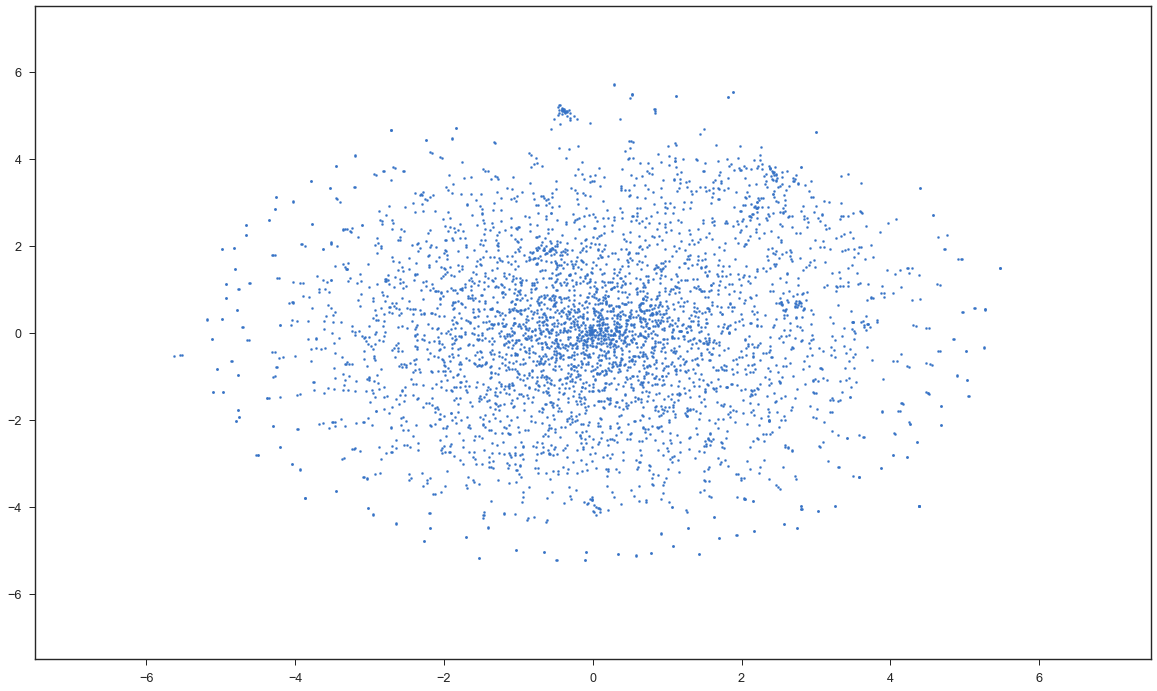

In [271]:
# create a scatterplot of the resulting 2-dimensional data
plt.figure(figsize=(20,12))
plt.scatter(df_tsne['x'], df_tsne['y'], s=5)

# zoom in on great majority of points
plt.xlim((-7.5,7.5))
plt.ylim((-7.5,7.5));

##### Some clustering but mostly just a big blob. Let's see if there's any relationship between genre and proximity.
### Scatterplot -- all genres

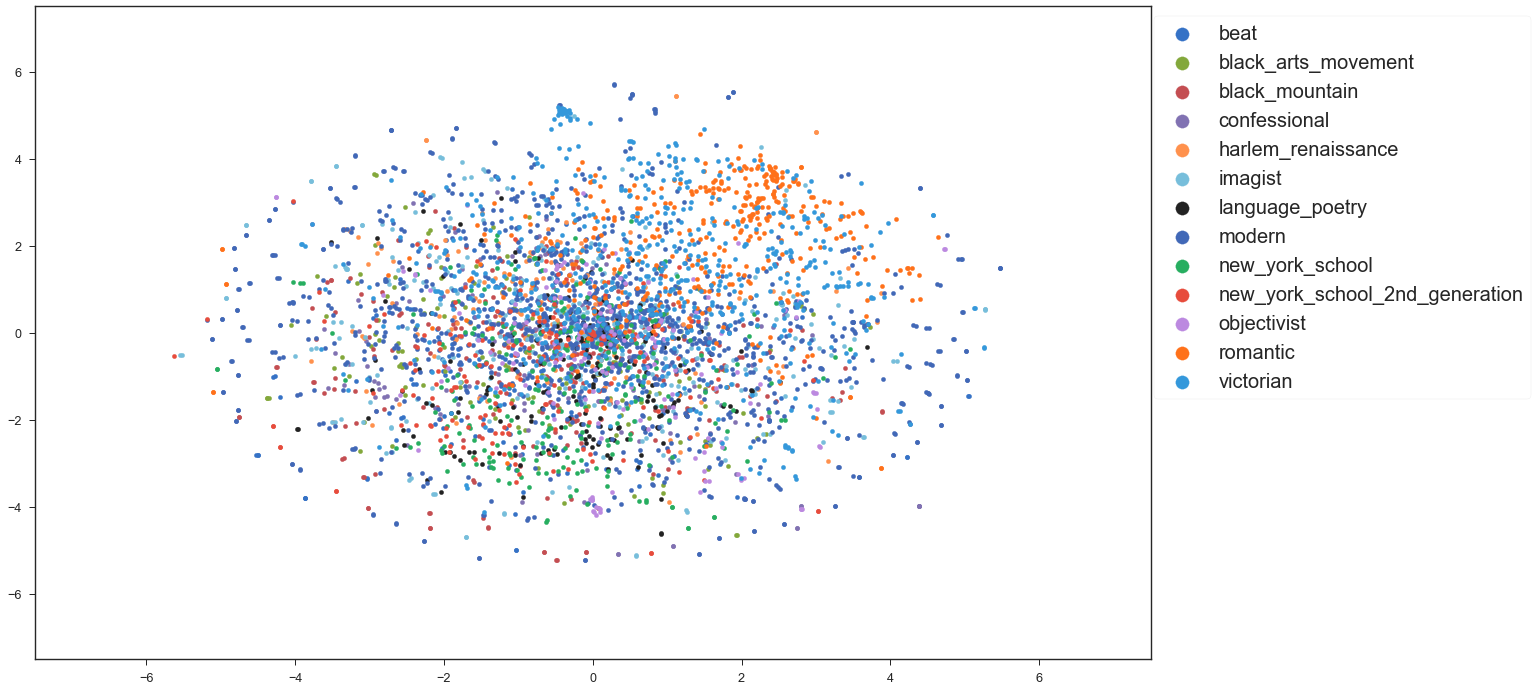

In [299]:
# create a list of all genres
genres = df['genre'].unique()

# iterate through every unique genre and plot with color
fig = plt.figure(figsize=(20,12))
ax = plt.subplot(111)
for genre in genres:
    genre_subset = make_tsne_subset(df_tsne, df, 'genre', genre)
    plt.scatter(genre_subset['x'], genre_subset['y'], s=20)

# adjust legend
ax.legend(genres, bbox_to_anchor=(1.35,1), markerscale=3, fontsize=20)

# zoom in on great majority of points
plt.xlim((-7.5,7.5))
plt.ylim((-7.5,7.5));

##### Some clustering seems apparent but also a lot of noise. Also, it's difficult to differentiate due to similar colors. We might be able to clarify by looking at umbrella genres.
### Scatterplot -- umbrella genres

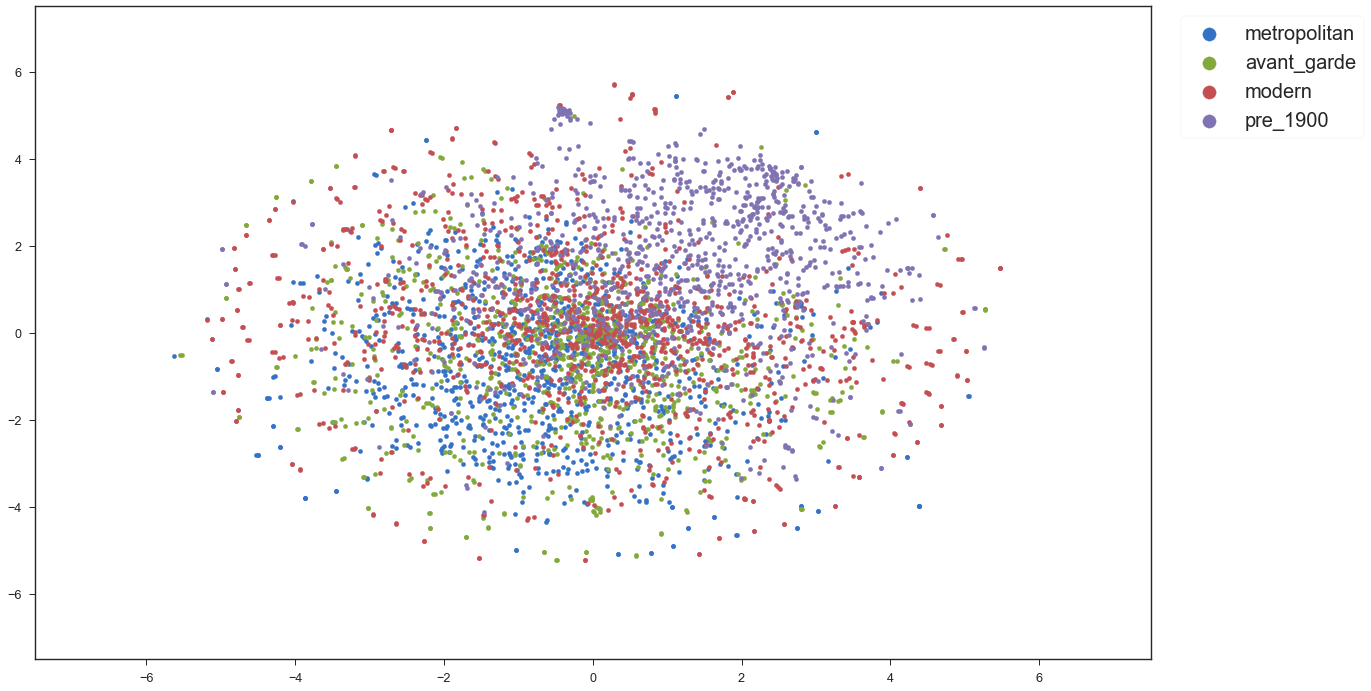

In [301]:
# create a list of all umbrella genres
genres = df['umbrella_genre'].unique()

# iterate through every unique genre and plot with color
fig = plt.figure(figsize=(20,12))
ax = plt.subplot(111)
for genre in genres:
    genre_subset = make_tsne_subset(df_tsne, df, 'umbrella_genre', genre)
    plt.scatter(genre_subset['x'], genre_subset['y'], s=20)

# adjust legend
ax.legend(genres, bbox_to_anchor=(1.2,1), markerscale=3, fontsize=20)

# zoom in on great majority of points
ax.set_xlim((-7.5,7.5))
ax.set_ylim((-7.5,7.5));

##### Some definite relationships here, but also a fair amount of overlap.
##### This appears to confirm the separation of Pre-1900 poetry fairly nicely, though plenty of overlap remains
##### The other three umbrella genres seem fairly similar to each other.
##### FUTURE CONSIDERATION: do some LDA modeling to determine if that contributes to a Doc2Vec vector.
## Test out some similarities

In [320]:
similar_poems = word_similarity('fire', df, model, num_poems=5, to_print=True)
similar_poems

33.9% match
LOVE'S NOCTURN by Dante Gabriel Rossetti
GENRE: Victorian
URL: https://www.poetryfoundation.org/poems/45020/loves-nocturn
----------------------------------------------------------------------------------------------------
29.2% match
IN CHAINS by William Carlos Williams
GENRE: Imagist
URL: https://www.poetryfoundation.org/poetrymagazine/poems/22431/in-chains
----------------------------------------------------------------------------------------------------
28.2% match
THE GLASS BUBBLES by Samuel Greenberg
GENRE: Modern
URL: https://www.poetryfoundation.org/poems/55891/the-glass-bubbles
----------------------------------------------------------------------------------------------------
27.4% match
LIFE AT WAR by Denise Levertov
GENRE: Black Mountain
URL: https://www.poetryfoundation.org/poetrymagazine/poems/30331/life-at-war
----------------------------------------------------------------------------------------------------
25.4% match
THE LAW  by Fanny Howe
GENRE: Languag

[(4213, 0.3390927314758301),
 (1194, 0.29221412539482117),
 (1744, 0.28201770782470703),
 (508, 0.2737388014793396),
 (1379, 0.2542811334133148)]

In [308]:
similar_poems = text_similarity('Demand for Coronavirus Testing in U.S. Soars, Creating a New Crisis',
                                df, model, num_poems=5, to_print=True)
similar_poems

45.3% match
RITUAL VIII by Paul Blackburn
GENRE: Black Mountain
URL: https://www.poetryfoundation.org/poetrymagazine/poems/30469/ritual-viii
----------------------------------------------------------------------------------------------------
43.7% match
LAWYER AND CHILD by James Whitcomb Riley
GENRE: Victorian
URL: https://www.poetryfoundation.org/poems/52700/lawyer-and-child
----------------------------------------------------------------------------------------------------
43.4% match
PARTURITION by Mina Loy
GENRE: Modern
URL: https://www.poetryfoundation.org/poems/145363/parturition
----------------------------------------------------------------------------------------------------
42.7% match
DAILY PRAYER by Marion Strobel
GENRE: Modern
URL: https://www.poetryfoundation.org/poetrymagazine/poems/15532/daily-prayer
----------------------------------------------------------------------------------------------------
42.3% match
LOOKING FORWARD by Robert Louis Stevenson
GENRE: Victorian

[(320, 0.45319321751594543),
 (4160, 0.43660691380500793),
 (1931, 0.43412643671035767),
 (2382, 0.42675042152404785),
 (4230, 0.42276883125305176)]

In [319]:
similar_poems = poem_similarity('Blizzard', df, model, num_poems=5, to_print=True)
similar_poems

43.3% match
MONOTONE by Carl Sandburg
GENRE: Modern
URL: https://www.poetryfoundation.org/poetrymagazine/poems/13230/monotone
----------------------------------------------------------------------------------------------------
42.0% match
YOU, ANDREW MARVELL by Archibald MacLeish
GENRE: Modern
URL: https://www.poetryfoundation.org/poems/43003/you-andrew-marvell
----------------------------------------------------------------------------------------------------
40.8% match
MAYAKOVSKY by Frank O'Hara
GENRE: New York School
URL: https://www.poetryfoundation.org/poems/53219/mayakovsky
----------------------------------------------------------------------------------------------------
40.7% match
ONE OF THE HUNDRED VIEWS OF FUJI BY HOKUSAI by Amy Lowell
GENRE: Imagist
URL: https://www.poetryfoundation.org/poetrymagazine/poems/13620/one-of-the-hundred-views-of-fuji-by-hokusai
----------------------------------------------------------------------------------------------------
39.7% match
SMAL

[(2180, 0.43266022205352783),
 (1957, 0.4200693368911743),
 (2901, 0.40760982036590576),
 (1028, 0.40650951862335205),
 (621, 0.3971850872039795)]